## Introduction

In [1]:
from dotenv import load_dotenv
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds
import keras
import joblib

## Get the Data

In [2]:
train_data, validation_data, test_data = tfds.load("imdb_reviews",
                                                   split=('train[:60%]', 'train[40%:]', 'test'),
                                                   as_supervised=True)

## Explore the Data

In [3]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(5)))

In [4]:
train_examples_batch

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [5]:
train_labels_batch

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 1, 1], dtype=int64)>

## Build the Model

In [6]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"

model = keras.Sequential([
    hub.KerasLayer(embedding, dtype = tf.string, input_shape=[], output_shape=[50], trainable=True),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 48,195,977
Trainable params: 48,195,977
Non-trainable params: 0
____________________________________________

## Compile the Model

In [7]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=tf.keras.metrics.BinaryAccuracy())

## Train the Model

In [8]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                        mode='max',
                                        patience=2,
                                        restore_best_weights=True,
                                        verbose=1)

In [9]:
batch_size=512
train_data = train_data.batch(batch_size)
validation_data=validation_data.batch(batch_size)

history = model.fit(train_data.shuffle(10000),
                    validation_data = validation_data,
                    epochs=100,
                    verbose=1,
                    callbacks=[earlystopping])

Epoch 1/100
30/30 [==============================] - 27s 895ms/step - loss: 0.7039 - binary_accuracy: 0.5045 - val_loss: 0.6884 - val_binary_accuracy: 0.5001
Epoch 2/100
30/30 [==============================] - 29s 980ms/step - loss: 0.6824 - binary_accuracy: 0.5281 - val_loss: 0.6557 - val_binary_accuracy: 0.6329
Epoch 3/100
30/30 [==============================] - 28s 938ms/step - loss: 0.6456 - binary_accuracy: 0.6801 - val_loss: 0.6086 - val_binary_accuracy: 0.7848
Epoch 4/100
30/30 [==============================] - 27s 911ms/step - loss: 0.5990 - binary_accuracy: 0.8066 - val_loss: 0.5759 - val_binary_accuracy: 0.8485
Epoch 5/100
30/30 [==============================] - 29s 954ms/step - loss: 0.5671 - binary_accuracy: 0.8763 - val_loss: 0.5643 - val_binary_accuracy: 0.8638
Epoch 6/100
30/30 [==============================] - 40s 1s/step - loss: 0.5486 - binary_accuracy: 0.9104 - val_loss: 0.5572 - val_binary_accuracy: 0.8873
Epoch 7/100
30/30 [==============================] - 37

In [17]:
model.save('sentiment_analysis')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: sentiment_analysis\assets
INFO:tensorflow:Assets written to: sentiment_analysis\assets


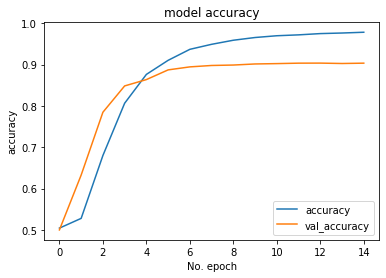

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

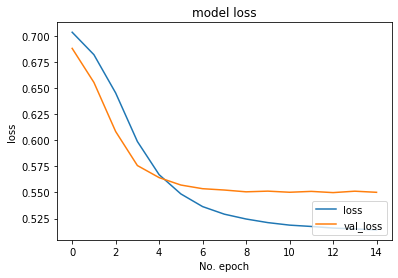

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.show()

## Evaluate the Model

In [14]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.5719 - binary_accuracy: 0.8564
loss: 0.572
binary_accuracy: 0.856


In [15]:
sample_text = ("I like the cats")

In [16]:
model.predict(np.array([sample_text]))

array([[0.9617769]], dtype=float32)